Michael Muschitiello // Interest Rate Derivatives // Barbell Trading Strategy 

In [2]:
import numpy as np 
import pandas as pd 
import yfinance as yf 
import datetime as dt 
import matplotlib.pyplot as plt 

from fredapi import Fred
API_KEY = "9da7edac51a3a1adab2418a20abb4d0d"
# initialize fredAPI
fred = Fred(api_key=API_KEY)

In [3]:
end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=365)

# fred series IDs
series_IDs = {
    "2yr": "DGS2",
    "5yr": "DGS5",
    "10yr": "DGS10",
}

# fetch data, weekly freq   
treasury_data = {}
for label, sid in series_IDs.items():
    ts = fred.get_series(
        series_id=sid,
        observation_start=start_date,
        observation_end=end_date,
        frequency="w",
    )
    treasury_data[label] = ts
# combine into a df
df = pd.DataFrame(treasury_data)
df.index.name = "Date"
df = df.dropna()

df.head()

,2yr,5yr,10yr
Date,,,
2024-03-08,4.54,4.12,4.13
2024-03-15,4.62,4.21,4.21
2024-03-22,4.64,4.28,4.28
2024-03-29,4.56,4.21,4.22
2024-04-05,4.70,4.34,4.35


In [4]:
def zero_coupon_analytics(y_percent, T):
    """
    Zero-coupon approximation:
      P = exp(-y * T)
      Duration ~ T * exp(-y*T)
      Convexity ~ T^2 * exp(-y*T)
    y_percent: yield in PERCENT 
    T: maturity in years
    """
    y = y_percent / 100.0  # convert from percent to decimal
    price = np.exp(-y * T)
    duration = T * np.exp(-y * T)      # continuous version
    convexity = (T**2) * np.exp(-y * T)
    return price, duration, convexity

# create new columns in df for price, duration, convexity for each maturity
results = []

for date, row in df.iterrows():
    # extract yields from the row
    y2, y5, y10 = row["2yr"], row["5yr"], row["10yr"]
    
    p2, d2, c2 = zero_coupon_analytics(y2, 2)
    p5, d5, c5 = zero_coupon_analytics(y5, 5)
    p10, d10, c10 = zero_coupon_analytics(y10, 10)
    
    results.append([
        date, p2, d2, c2, p5, d5, c5, p10, d10, c10
    ])

# build a new df from results
cols = [
    "Date",
    "P2yr", "D2yr", "C2yr",
    "P5yr", "D5yr", "C5yr",
    "P10yr","D10yr","C10yr"
]
analytics_df = pd.DataFrame(results, columns=cols).set_index("Date")

analytics_df.head()


,P2yr,D2yr,C2yr,P5yr,D5yr,C5yr,P10yr,D10yr,C10yr
Date,,,,,,,,,
2024-03-08,0.913200,1.826401,3.652801,0.813833,4.069165,20.345827,0.661662,6.616623,66.166228
2024-03-15,0.911740,1.823481,3.646962,0.810179,4.050895,20.254476,0.656390,6.563901,65.639010
2024-03-22,0.911376,1.822752,3.645503,0.807348,4.036742,20.183710,0.651811,6.518114,65.181141
2024-03-29,0.912835,1.825670,3.651341,0.810179,4.050895,20.254476,0.655734,6.557340,65.573404
2024-04-05,0.910283,1.820566,3.641131,0.804930,4.024650,20.123249,0.647265,6.472647,64.726467


In [5]:
def solve_butterfly(P2, D2, C2, 
                    P5, D5, C5, 
                    P10, D10, C10):
    """
    Solve the system for w2, w5, w10:
      w2*P2 - 2*w5*P5 + w10*P10 = 0   (net cost = 0)
      w2*D2 - 2*w5*D5 + w10*D10 = 0   (net duration = 0)
    subject to 
      w2*C2 - 2*w5*C5 + w10*C10 > 0   (net convexity > 0).
    
    We'll fix w5 = 1 for convenience, then solve for w2 and w10.
    """
    # Fix w5 = -1
    w5 = -1.0
    
    # the two linear equations become:
    #    w2*P2 + w10*P10 = 2 * P5   (1')
    #    w2*D2 + w10*D10 = 2 * D5   (2')
    
    A = np.array([
        [P2,   P10],
        [D2,   D10]
    ], dtype=float)
    
    b = np.array([
        2.0 * P5,
        2.0 * D5
    ], dtype=float)
    
    # solve A * [w2, w10]^T = b
    w2, w10 = np.linalg.solve(A, b)
    
    # check net convexity
    net_cx = w2*C2 - 2*w5*C5 + w10*C10
    if net_cx < 0:
        w2, w5, w10 = -w2, -w5, -w10
        net_cx = -net_cx
    
    return w2, w5, w10, net_cx


weights_records = []

for date, row in analytics_df.iterrows():
    P2, D2, C2 = row['P2yr'], row['D2yr'], row['C2yr']
    P5, D5, C5 = row['P5yr'], row['D5yr'], row['C5yr']
    P10, D10, C10 = row['P10yr'], row['D10yr'], row['C10yr']
    
    w2, w5, w10, net_cx = solve_butterfly(
        P2, D2, C2,
        P5, D5, C5,
        P10, D10, C10
    )
    
    weights_records.append([date, w2, w5, w10, net_cx])

weights_df = pd.DataFrame(
    weights_records, 
    columns=['Date', 'w2yr', 'w5yr', 'w10yr', 'net_convexity']
).set_index('Date')

weights_df.head()


,w2yr,w5yr,w10yr,net_convexity
Date,,,,
2024-03-08,1.113985,-1.0,0.922487,105.798300
2024-03-15,1.110759,-1.0,0.925721,105.323277
2024-03-22,1.107321,-1.0,0.928967,104.955290
2024-03-29,1.109427,-1.0,0.926647,105.323277
2024-04-05,1.105330,-1.0,0.932690,104.640896


In [6]:
# merge weekly analytics and weights
combined = analytics_df.join(weights_df, how="inner")

# shift the analytics by -1 to get next week's price for PnL
combined_shifted = combined.shift(-1).dropna()

pnl_records = []

for (date, row), (next_date, next_row) in zip(combined.iterrows(), combined_shifted.iterrows()):
    # weights for this date
    w2, w5, w10 = row["w2yr"], row["w5yr"], row["w10yr"]
    
    # current prices
    P2_now, P5_now, P10_now = row["P2yr"], row["P5yr"], row["P10yr"]
    # next weeks prices
    P2_next, P5_next, P10_next = next_row["P2yr"], next_row["P5yr"], next_row["P10yr"]
    
    # PnL
    pnl = (w2*(P2_next - P2_now) 
         + w5*(P5_next - P5_now) 
         + w10*(P10_next - P10_now))
    
    pnl_records.append([date, pnl])

pnl_df = pd.DataFrame(pnl_records, columns=["Date","PnL"]).set_index("Date")
pnl_df["CumulativePnL"] = pnl_df["PnL"].cumsum()
pnl_df.head()


,PnL,CumulativePnL
Date,,
2024-03-08,-0.002836,-0.002836
2024-03-15,-0.001813,-0.004649
2024-03-22,0.002429,-0.002219
2024-03-29,-0.005431,-0.007650
2024-04-05,-0.004199,-0.011849


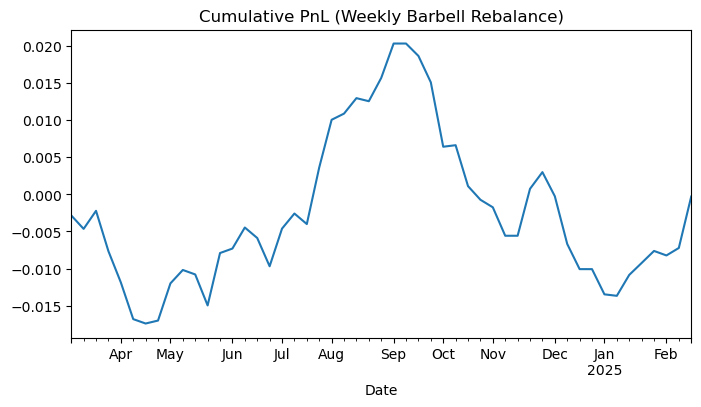

In [7]:
pnl_df["CumulativePnL"].plot(figsize=(8,4), title="Cumulative PnL (Weekly Barbell Rebalance)")
plt.show()
